# EncoderDecoder Sequence Fibrosis Progression

## 1. Libraries

In [1]:
#########################################################################
# 01. Libraries

import time
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import glob
from sklearn.model_selection import KFold, StratifiedKFold

import tensorflow as tf
# import tensorflow_addons as tfa
tf.keras.backend.clear_session()
import tensorflow_probability as tfp
tfd = tfp.distributions

# To allocate memory dynamically
physical_devices = tf.config.list_physical_devices('GPU')

try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    print('Invalid device or cannot modify virtual devices once initialized.')
# tf.config.experimental.enable_mlir_graph_optimization()

from tensorflow.keras import layers, models, optimizers, regularizers, constraints, initializers
from tensorflow.keras.utils import Sequence

from Utils.utils import *
from Utils.attention_layers import BahdanauAttention, ScaledDotProductAttention, GeneralAttention, VisualAttentionBlock
from Utils.preprocess_scans import *

pd.set_option('display.max_colwidth', 1000)

import warnings
warnings.filterwarnings("ignore")
import scipy as sp
import math
from functools import partial

#########################################################################

## 2. Global Variables

In [2]:
#########################################################################
# 02. Global Variables

path = '../../01_Data/'
path_models = '../../05_Saved_Models/'

path_train_masks = path + '/train_masks_fast_masks/'
path_test_masks = path + '/test_masks_fast_masks/'

path_scans_train = path + 'train/'
path_scans_test = path + 'test/'

#########################################################################

## 3. Load Data & Preprocess Data

In [3]:
##################################################################################################
# 03. Load Data & Preprocess Data

df_train = pd.read_csv( path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')

print(f'1.1 -> There are {df_train.Patient.unique().shape[0]} train unique patients')
print(f'1.2 -> There are {df_test.Patient.unique().shape[0]} test unique patients')

train_mask_paths = glob.glob(path_train_masks + '*')
test_mask_paths = glob.glob(path_test_masks + '*')

print(f'No. of Train Masks : {len(train_mask_paths)}')
print(f'No. of Test Masks : {len(test_mask_paths)}')
      
unique_train_patients = df_train.Patient.unique()
unique_test_patients = df_test.Patient.unique()

train_patients = os.listdir(path_train_masks)
test_patients = os.listdir(path_test_masks)

dict_train_patients_masks_paths = {patient: path_train_masks + patient + '/' for patient in train_patients}
dict_test_patients_masks_paths = {patient: path_test_masks + patient + '/' for patient in test_patients}

dict_train_patients_scans_paths = {patient: path_scans_train + patient + '/' for patient in unique_train_patients}
dict_test_patients_scans_paths = {patient: path_scans_test + patient + '/' for patient in unique_test_patients}

for patient in tqdm(dict_train_patients_masks_paths):
    list_files = os.listdir(dict_train_patients_masks_paths[patient])
    list_files = [dict_train_patients_masks_paths[patient] + file for file in list_files]
    dict_train_patients_masks_paths[patient] = list_files
    
for patient in tqdm(dict_test_patients_masks_paths):
    list_files = os.listdir(dict_test_patients_masks_paths[patient])
    list_files = [dict_test_patients_masks_paths[patient] + file for file in list_files]
    dict_test_patients_masks_paths[patient] = list_files
    

for patient in tqdm(dict_train_patients_scans_paths):
    list_files = os.listdir(dict_train_patients_scans_paths[patient])
    list_files = [dict_train_patients_scans_paths[patient] + file for file in list_files]
    dict_train_patients_scans_paths[patient] = list_files
    
for patient in tqdm(dict_test_patients_scans_paths):
    list_files = os.listdir(dict_test_patients_scans_paths[patient])
    list_files = [dict_test_patients_scans_paths[patient] + file for file in list_files]
    dict_test_patients_scans_paths[patient] = list_files
    
# Preprocessing:

df_train = df_train.groupby(['Patient', 'Weeks']).agg({
    'FVC': np.mean,
    'Percent': np.mean,
    'Age': np.max,
    'Sex': np.max,
    'SmokingStatus': np.max 
}).reset_index()

df_train['FVC_Percent'] = (df_train['FVC'] / df_train['Percent']) * 100
df_test['FVC_Percent'] = (df_test['FVC'] / df_test['Percent']) * 100


# Standarize data

mean_fvc, std_fvc = df_train.FVC.mean(), df_train.FVC.std()
mean_perc, std_perc = df_train.Percent.mean(), df_train.Percent.std()
mean_age, std_age = df_train.Age.mean(), df_train.Age.std()

df_train['Age'] = df_train['Age'].apply(lambda x: (x-mean_age)/std_age)
df_test['Age'] = df_test['Age'].apply(lambda x: (x-mean_age)/std_age)

df_train['FVC'] = df_train['FVC'].apply(lambda x: (x-mean_fvc)/std_fvc)
df_test['FVC'] = df_test['FVC'].apply(lambda x: (x-mean_fvc)/std_fvc)
df_train['FVC_Percent'] = df_train['FVC_Percent'].apply(lambda x: (x-mean_fvc)/std_fvc)
df_test['FVC_Percent'] = df_test['FVC_Percent'].apply(lambda x: (x-mean_fvc)/std_fvc)

df_train['Percent'] = df_train['Percent'].apply(lambda x: (x-mean_perc)/std_perc)
df_test['Percent'] = df_test['Percent'].apply(lambda x: (x-mean_perc)/std_perc)

# Mapping categories dictionaries 

dict_sex = {'Male': 0, 'Female': 1}
dict_sex_inv = {0: 'Male', 1: 'Female'}

dict_smoke = {'Ex-smoker': 0, 'Never smoked': 1, 'Currently smokes': 2}
dict_smoke_inv = {0: 'Ex-smoker', 1:'Never smoked', 2:'Currently smokes'}

dict_kind_patient = {'decreased': 0, 'regular': 1, 'increased': 2}
dict_kind_patient_inv = {0: 'decreased', 1: 'regular', 2: 'increased'}

df_train.Sex = df_train.Sex.apply(lambda x: dict_sex[x])
df_train.SmokingStatus = df_train.SmokingStatus.apply(lambda x: dict_smoke[x])

df_test.Sex = df_test.Sex.apply(lambda x: dict_sex[x])
df_test.SmokingStatus = df_test.SmokingStatus.apply(lambda x: dict_smoke[x])

# Build WeeksSinceLastVisit feature

df_train['ElapsedWeeks'] = df_train['Weeks']
df_test['ElapsedWeeks'] = df_test['Weeks']

train_weeks_elapsed = df_train.set_index(['Patient', 'Weeks'])['ElapsedWeeks'].diff().reset_index()
test_weeks_elapsed = df_test.set_index(['Patient', 'Weeks'])['ElapsedWeeks'].diff().reset_index()

df_train = df_train.drop('ElapsedWeeks', axis=1)
df_test = df_test.drop('ElapsedWeeks', axis=1)

train_weeks_elapsed['ElapsedWeeks'] = train_weeks_elapsed['ElapsedWeeks'].fillna(0).astype(int)
test_weeks_elapsed['ElapsedWeeks'] = test_weeks_elapsed['ElapsedWeeks'].fillna(0).astype(int)

df_train = df_train.merge(train_weeks_elapsed, how='inner', on=['Patient', 'Weeks'])
df_test = df_test.merge(test_weeks_elapsed, how='inner', on=['Patient', 'Weeks'])

df_train['patient_row'] = df_train.sort_values(['Patient', 'Weeks'], ascending=[True, True]) \
             .groupby(['Patient']) \
             .cumcount() + 1

df_test['patient_row'] = df_test.sort_values(['Patient', 'Weeks'], ascending=[True, True]) \
             .groupby(['Patient']) \
             .cumcount() + 1

df_train['WeeksSinceLastVisit'] = df_train.apply(lambda x: x['Weeks'] if x['patient_row']==1 else x['ElapsedWeeks'], axis=1)
df_test['WeeksSinceLastVisit'] = df_test.apply(lambda x: x['Weeks'] if x['patient_row']==1 else x['ElapsedWeeks'], axis=1)

# Norm Weeks

mean_weeks, std_weeks = df_train.Weeks.mean(), df_train.Weeks.std()

df_train['WeeksSinceLastVisit'] = df_train['WeeksSinceLastVisit'].apply(lambda x: (x-mean_weeks)/std_weeks)
df_test['WeeksSinceLastVisit'] = df_test['WeeksSinceLastVisit'].apply(lambda x: (x-mean_weeks)/std_weeks)


df_train['Weeks'] = df_train['Weeks'].apply(lambda x: (x-mean_weeks)/std_weeks)
df_test['Weeks'] = df_test['Weeks'].apply(lambda x: (x-mean_weeks)/std_weeks)

# Ini dictionaries

columns = ['FVC', 'Age', 'Sex', 'SmokingStatus', 'WeeksSinceLastVisit', 'Percent']
dict_patients_train_ini_features, dict_patients_test_ini_features = {}, {}
dict_patients_train_kind_patient, dict_patients_test_kind_patient = {}, {}
df_train_patients, df_test_patients = df_train.set_index('Patient'), df_test.set_index('Patient')

for patient in unique_train_patients:
    dict_patients_train_ini_features[patient] = df_train_patients[columns][df_train_patients.index==patient].\
                                                                    to_dict('records')[0]
    std = np.std(unscale(df_train_patients['FVC'][df_train_patients.index==patient], mean_fvc, std_fvc).values)
    mean_first_1 = np.mean(unscale(df_train_patients['FVC'][df_train_patients.index==patient], mean_fvc, std_fvc).values[:1])
    mean_last_1 = np.mean(unscale(df_train_patients['FVC'][df_train_patients.index==patient], mean_fvc, std_fvc).values[-1:])
    if std<=100:
        dict_patients_train_kind_patient[patient] = 'regular'
    elif std>100 and mean_last_1 > mean_first_1 :
        dict_patients_train_kind_patient[patient] = 'increased'
    elif std>100 and mean_last_1 <= mean_first_1 :
        dict_patients_train_kind_patient[patient] = 'decreased'
    dict_patients_train_ini_features[patient]['kind'] = dict_kind_patient[dict_patients_train_kind_patient[patient]]
        
    
for patient in unique_test_patients:
    dict_patients_test_ini_features[patient] = df_test_patients[columns][df_test_patients.index==patient].\
                                                                    to_dict('records')[0]
    std = np.std(unscale(df_train_patients['FVC'][df_train_patients.index==patient], mean_fvc, std_fvc).values)
    mean_first_1 = np.mean(unscale(df_train_patients['FVC'][df_train_patients.index==patient], mean_fvc, std_fvc).values[:1])
    mean_last_1 = np.mean(unscale(df_train_patients['FVC'][df_train_patients.index==patient], mean_fvc, std_fvc).values[-1:])
    if std<=100:
        dict_patients_test_kind_patient[patient] = 'regular'
    elif std>100 and mean_last_1 > mean_first_1 :
        dict_patients_test_kind_patient[patient] = 'increased'
    elif std>100 and mean_last_1 <= mean_first_1 :
        dict_patients_test_kind_patient[patient] = 'decreased'
    dict_patients_test_ini_features[patient]['kind'] = dict_kind_patient[dict_patients_test_kind_patient[patient]]

# Decoder inputs

dict_train_sequence_fvc, dict_train_sequence_weekssincelastvisit = {}, {}
dict_train_sequence_cumweeks = {}
for patient in unique_train_patients:
    dict_train_sequence_fvc[patient] = list(df_train_patients['FVC'].loc[patient].values[1:])
    dict_train_sequence_weekssincelastvisit[patient] = list(df_train_patients['WeeksSinceLastVisit'].loc[patient].values[1:])
    dict_train_sequence_cumweeks[patient] = list(df_train_patients['Weeks'].loc[patient].values[1:])

##################################################################################################

100%|██████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 5060.69it/s]

1.1 -> There are 176 train unique patients
1.2 -> There are 5 test unique patients
No. of Train Masks : 176
No. of Test Masks : 5


## 4. Data Generator

Similar as `03_Autoencoder` Training Generator but instead of imgs as output we will have the ini features that we will use as our encoder input

In [4]:
#########################################################################

## 04. Data Generator

class SequenceToSequenceDataGenerator(Sequence):
    
    def __init__(self, raw_scans, training, patients, dict_ini_features, dict_patients_masks_paths,
                 batch_size=1, num_frames_batch=32, dict_raw_scans_paths=None, 
                 alpha=1.0, random_window=False, center_crop=True,
                 img_size_load=(500, 500, 3), 
                 img_size_crop=(440, 440, 3)):
        
        super(SequenceToSequenceDataGenerator, self).__init__()
        self.raw_scans = raw_scans
        self.training = training
        self.dict_ini_features = dict_ini_features
        self.batch_size = batch_size
        self.num_frames_batch = num_frames_batch
        self.alpha = alpha

        self.random_window = random_window
        self.center_crop = center_crop
        self.img_size_load = img_size_load
        self.img_size_crop = img_size_crop
        
        self.dict_patients_masks_paths = dict_patients_masks_paths
        self.dict_raw_scans_paths = dict_raw_scans_paths
        
        self.ids = patients
#         self.pre_calculated_mean = 0.02865046213070556
        self.num_steps = int(np.ceil(len(self.ids) / self.batch_size))
        self.on_epoch_end()
      
    # Number of batches in the sequence
    
    def __len__(self):
        return self.num_steps
    
    
    # Gets the batch at position index, return patient images and dict ini features
    
    def __getitem__(self, idx):
        indexes = self.indexes[idx*self.batch_size:(idx+1)*self.batch_size]
        patient_ids = [self.ids[k] for k in indexes]
        if not self.raw_scans:
            list_scan_imgs = [decodePatientImages(patient, 
                                                  self.dict_patients_masks_paths,
                                                  image_size=(self.img_size_load[0], self.img_size_load[1]), 
                                                  numpy=True) 
                              for patient in patient_ids]
        else:
            list_scan_imgs = self.preprocessRawScans(patient_ids)
           
        patient_imgs = self.groupImages(list_scan_imgs)
#         patient_imgs -= self.pre_calculated_mean
#         print(patient_imgs.shape)
#         patient_imgs = self.fullcenter3DCropping(patient_imgs)
#         print(patient_imgs.shape) 
        patient_imgs = self.loadImagesAugmented(patient_imgs)
        for patient_ in patient_ids:
            self.dict_ini_features[patient_]['Patient'] = patient_
        return (patient_imgs, [self.dict_ini_features[patient_] for patient_ in patient_ids])
    
    
    # Preprocess Raw Scans in dicom format
    
    def preprocessRawScans(self, patient_ids):
        patients_files = [self.dict_raw_scans_paths[patient] for patient in patient_ids]
        patients_slices = [loadSlices(p) for p in patients_files]
        patients_images = [getPixelsHu(p_slices) for p_slices in patients_slices]
        patients_resampled_imgs = [resampleImages(p_images, p_slice, [1, 1, 1])[0] \
                                            for p_images, p_slice in zip(patients_images, patients_slices)]
        patients_crop_imgs = [np.asarray([imCropCenter(img, 320, 320) for img in p_resampled_imgs]) \
                              for p_resampled_imgs in patients_resampled_imgs]
        patients_segmented_lungs_fill = [np.asarray([seperateLungs(img, n_iters=2, only_internal=False, only_watershed=True)
                                                    for img in p_crop_imgs]) for p_crop_imgs in patients_crop_imgs]
        patients_masked_imgs = [np.where(p_lungs_fill==255, p_imgs, -2_048) \
                                for p_lungs_fill, p_imgs in zip(patients_segmented_lungs_fill, patients_crop_imgs)]
        
        patients_imgs = [windowImageNorm(p_imgs, min_bound=-1_000, max_bound=400) for p_imgs in patients_masked_imgs]
        patients_imgs = [tf.convert_to_tensor(img, dtype=tf.float32) for img in patients_imgs]
        patients_img_resized = [tf.convert_to_tensor([tf.image.resize(tf.expand_dims(img, axis=2), 
                                                                      (self.img_size_load[0], self.img_size_load[1])) 
                                                      for img in p_imgs], 
                                           dtype=tf.float32) for p_imgs in patients_imgs]
        return patients_img_resized
        
    
    # From n patient frames we will only keep self.alpha*n frames, cutting on top and bottom
    
    def filterSlices(self, array_imgs):
        num_patient_slices = array_imgs.shape[0]
        beta = int(self.alpha * num_patient_slices)
        if beta % 2 != 0:
            beta += 1
        if num_patient_slices > self.num_frames_batch:
            if beta > self.num_frames_batch and self.alpha < 1:
                remove = int((num_patient_slices - beta)/2)
                array_imgs = array_imgs[remove:, :, :, :]
                array_imgs = array_imgs[:-remove:, :, :]

        return array_imgs
    
    # Skip frames unniformally according to self.num_frames_batch value
    
    def frameSkipImages(self, patient_imgs):
        num_patient_slices = patient_imgs.shape[0]
        frame_skip = num_patient_slices // self.num_frames_batch
        skipped_patient_imgs = np.zeros((self.num_frames_batch, self.img_size_load[0], self.img_size_load[1], 1))
        for i in range(self.num_frames_batch):
            skipped_patient_imgs[i] = patient_imgs[i*frame_skip]    
        return skipped_patient_imgs
    
    # Select a random window of patient frames, in case its images has more frames than self.num_frame_batch 
    
    def randomWindow(self, patient_imgs):
        windowed_imgs = np.zeros((self.num_frames_batch, patient_imgs.shape[1], patient_imgs.shape[2], 1))
        num_frames = patient_imgs.shape[0]
        if num_frames < self.num_frames_batch:
            windowed_imgs[:num_frames] = patient_imgs
        else:
            random_frames = np.arange(num_frames)
            index = np.random.randint(0, num_frames - self.num_frames_batch)
            windowed_imgs[0:] = patient_imgs[index:index+self.num_frames_batch]
        return windowed_imgs
            
    
    # Convert raw frames to a fix size array -> (batch_size, num_frames_batch, img_size_crop[0], img_size_crop[1], 1)
    
    def groupImages(self, list_scan_imgs):
        grouped_imgs = []
        for patient_imgs in list_scan_imgs:
            if patient_imgs.shape[1] > self.num_frames_batch:
                patient_imgs = self.filterSlices(patient_imgs)
            if self.random_window:
                patient_imgs = self.randomWindow(patient_imgs)
            else:
                patient_imgs = self.frameSkipImages(patient_imgs)
            grouped_imgs.append(patient_imgs)
        return np.asarray(grouped_imgs)
        
    # Performs augmentation operations conserving the 3D property on the z axis
    
    def loadImagesAugmented(self, patient_imgs):

        if self.center_crop: #self.img_size_load != self.img_size_crop:
            # patient_imgs = self.center3Dcropping(patient_imgs)
            if patient_imgs.shape[2] > self.img_size_crop[0] and patient_imgs.shape[3] > self.img_size_crop[1]:
                patient_imgs = self.random3DCropping(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = np.fliplr(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = np.flipud(patient_imgs)
        if self.training and np.random.random() > 0.5:
            patient_imgs = patient_imgs[:, :, ::-1]
        if self.training and np.random.random() > 0.5:
            patient_imgs = patient_imgs[:, ::-1, :]
        if self.training:
            patient_rotated_imgs= []
            angle = np.random.randint(-15, 15)
            for batch in range(patient_imgs.shape[0]):
                batch_imgs_rotated = np.asarray([ndimage.rotate(patient_imgs[batch, i], angle, order=1,
                                                                reshape=False) for i in range(patient_imgs.shape[1])])
                patient_rotated_imgs.append(batch_imgs_rotated)
            patient_imgs = np.asarray(patient_rotated_imgs) 
        return patient_imgs
    
    # gull Center 3d Cropping 
    
    def fullcenter3DCropping(self, patient_imgs):
        cropped_imgs = []
        for batch in range(patient_imgs.shape[0]):
            imgs = np.asarray([cropLung(patient_imgs[batch, img].squeeze()) for img in range(patient_imgs.shape[1])])
            cropped_imgs.append(imgs)

        return np.expand_dims(np.asarray(cropped_imgs), axis=-1)
    
    #Random Cropping 3D - change x, y axis but not z
    
    def random3DCropping(self, patient_imgs):
        w, h = self.img_size_crop[0], self.img_size_crop[1]
        x = np.random.randint(0, patient_imgs.shape[2] - w)
        y = np.random.randint(0, patient_imgs.shape[2] - h)
        patient_crop_imgs = patient_imgs[:, :, y:y+h, x:x+w]
        return patient_crop_imgs
    
    # Center 3D Cropping
    
    def center3Dcropping(self, patient_imgs):
        w, h = patient_imgs.shape[2] - 20, patient_imgs.shape[3] - 20
        img_height, img_width = patient_imgs.shape[2], patient_imgs.shape[3]
        left, right = (img_width - w) / 2, (img_width + w) / 2
        top, bottom = (img_height - h) / 2, (img_height + h) / 2
        left, top = round(max(0, left)), round(max(0, top))
        right, bottom = round(min(img_width - 0, right)), round(min(img_height - 0, bottom))
        patient_crop_imgs = patient_imgs[:, :, top:bottom, left:right]
        return patient_crop_imgs
    
    # We shuffle the data at the end of each epoch
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.ids))
        np.random.shuffle(self.indexes)
     
    # Get only one patient, for debugging or prediction
        
    def getOnePatient(self, patient_id):
        if not self.raw_scans:
            list_scan_imgs = [decodePatientImages(patient_id, 
                                                  self.dict_patients_masks_paths,
                                                  image_size=(self.img_size_load[0], self.img_size_load[1]), 
                                                  numpy=True)]
        else:
            list_scan_imgs = self.preprocessRawScans([patient_id])
            
        patient_imgs = self.groupImages(list_scan_imgs)
        patient_imgs = self.loadImagesAugmented(patient_imgs)
        self.dict_ini_features[patient_id]['Patient'] = patient_id
        return (patient_imgs, [self.dict_ini_features[patient_id]])

    
#########################################################################

## 5. Model

## 5.1 Base Model

In [5]:
#########################################################################

## 05. Models

### 05.1 Backbone 3D Image Model

class BackBone3DModel(models.Model):
    
    def __init__(self, unet=False, path_unet=None, resnet=False, path_resnet=None, features_dim=256):
        super(BackBone3DModel, self).__init__(name='BackBone3DModel')
        self.unet = unet
        self.path_unet = path_unet
        self.resnet = resnet
        self.path_resnet = path_resnet
        if self.unet:
            self.unet_model = tf.keras.models.load_model(self.path_unet, compile=False) 
            self.unet_model.trainable = False
        if self.resnet:
            self.resnet_model = tf.keras.models.load_model(self.path_resnet, compile=False) 
            self.resnet_model.trainable = True 
        else:
            self.avg_pool = layers.AvgPool3D(pool_size=(2, 1, 1), name='avg_pool')
            
            self.input_batch_norm = layers.BatchNormalization()
            
            self.block1_conv1 = layers.Conv3D(32, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block1_conv1',
                                              data_format='channels_last')
            self.block1_conv2 = layers.Conv3D(32, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block1_conv2',
                                              data_format='channels_last')
            self.block1_maxpool1 = layers.MaxPool3D(pool_size=(2, 2, 2), name='block1_maxpool1',
                                              data_format='channels_last')
            self.block_1_dropout = layers.Dropout(0.2)

            self.block2_conv1 = layers.Conv3D(64, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block2_conv1',
                                              data_format='channels_last')
            self.block2_conv2 = layers.Conv3D(64, kernel_size=(1, 3, 3),padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block2_conv2',
                                              data_format='channels_last')
            self.block2_maxpool1 = layers.MaxPool3D(pool_size=(2, 2, 2), name='block2_maxpool1',
                                              data_format='channels_last')
            self.block_2_dropout = layers.Dropout(0.3)

            self.block3_conv1 = layers.Conv3D(128, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block3_conv1',
                                              data_format='channels_last')
            self.block3_conv2 = layers.Conv3D(128, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block3_conv2',
                                              data_format='channels_last')
            
            self.block_3_dropout = layers.Dropout(0.4)
            
            self.block3_maxpool1 = layers.MaxPool3D(pool_size=(2, 2, 2), name='block2_maxpool1',
                                              data_format='channels_last')

            self.block4_conv1 = layers.Conv3D(256, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block3_conv1',
                                              data_format='channels_last')
            self.block4_conv2 = layers.Conv3D(256, kernel_size=(1, 3, 3), padding='same', 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              kernel_initializer = initializers.RandomNormal(stddev=0.01),
                                              activation='relu', name='block3_conv2',
                                              data_format='channels_last')
            
            self.glob_max_pool = layers.GlobalMaxPooling3D()

        
    
    def call(self, inputs, training=True):
        if self.unet:
            x = self.unet_model(inputs, training)
            # (None, 2, 20, 20, 256)
        elif self.resnet:
            x = self.resnet_model(inputs, training)
        else:
            x = self.avg_pool(inputs)
#             x = self.input_batch_norm(x, training)
            
            x = self.block1_conv1(x)
            x = self.block1_conv2(x)
            x = self.block1_maxpool1(x)
            x = self.block_1_dropout(x, training)

            x = self.block2_conv1(x)
            x = self.block2_conv2(x)
            x = self.block2_maxpool1(x)
            x = self.block_2_dropout(x, training)

            x = self.block3_conv1(x)
            x = self.block3_conv2(x)
            x = self.block3_maxpool1(x)
            x = self.block_3_dropout(x, training)
            
            x = self.block4_conv1(x)
            x = self.block4_conv2(x)
            
            x = self.glob_max_pool(x)
            
        return x
    

### 05.2 Backbone Tabular Data for Patients metadata

class BackBoneTabularModel(models.Model):
    
    def __init__(self, dense_dim, dropout_rate, sex_dim=20, smoker_dim=20, max_norm=1):
        super(BackBoneTabularModel, self).__init__(name='BackBoneTabularModel')
        
        self.dense_dim = dense_dim
        self.dropout_rate = dropout_rate
 
        self.sex_dim = sex_dim 
        self.smoker_dim = smoker_dim
        
        # Embedding layers
        self.emb_sex = layers.Embedding(input_dim=2, output_dim=self.sex_dim, 
                                       embeddings_regularizer=regularizers.l2(1e-4))
                                       #embeddings_constraint=constraints.MaxNorm(max_norm))
                                    
        self.emb_smoker = layers.Embedding(input_dim=3, output_dim=self.smoker_dim,
                                           embeddings_regularizer=regularizers.l2(1e-4))
                                           #embeddings_constraint=constraints.MaxNorm(max_norm))
        
        self.emb_kind = layers.Embedding(input_dim=3, output_dim=self.smoker_dim,
                                         embeddings_regularizer=regularizers.l2(1e-4))
                                         #embeddings_constraint=constraints.MaxNorm(max_norm))
        
        # Output layer
        self.dropout_1 = layers.Dropout(self.dropout_rate)
        self.dense_1 = layers.Dense(units=self.dense_dim,
                                  activation=None,
                                  kernel_regularizer=regularizers.l2(1e-4),
                                  bias_regularizer=regularizers.l2(1e-4),
                                  activity_regularizer=regularizers.l2(1e-4),
                                  kernel_constraint = constraints.MaxNorm(max_norm),
                                  bias_constraint=constraints.MaxNorm(max_norm),
                                  name='tabular_dense1')
        self.batch_norm_1 = layers.BatchNormalization(axis=-1)
        
        self.dropout_2 = layers.Dropout(0.2)
        
        self.dense_2 = layers.Dense(units=self.dense_dim//2,
                                  activation=None,
                                  kernel_regularizer=regularizers.l2(1e-4),
                                  bias_regularizer=regularizers.l2(1e-4),
                                  activity_regularizer=regularizers.l2(1e-4),
                                  kernel_constraint = constraints.MaxNorm(max_norm),
                                  bias_constraint=constraints.MaxNorm(max_norm),
                                  name='tabular_dense2')
        self.batch_norm_2 = layers.BatchNormalization(axis=-1)
        
    def call(self, inputs, training=True):

        patient_sex = self.emb_sex(inputs[:, 0])
        patient_smoke = self.emb_smoker(inputs[:, 1])
        # patient_kind = self.emb_kind(inputs[:, 2])
        
        x = tf.concat([patient_sex,
                       patient_smoke,
                       # patient_kind,
                       tf.expand_dims(inputs[:, 2], 1), #Age
                       tf.expand_dims(inputs[:, 3], 1), # Percent
                       tf.expand_dims(inputs[:, 4], 1), # WeeksSinceLastVisit
                       tf.expand_dims(inputs[:, 5], 1)], # Ini FVC
                axis=-1) 
        
        x = self.dropout_1(x, training)
        x = self.dense_1(x)
#         x = self.batch_norm_1(x, training)
        x = tf.nn.relu(x)
        
#         x = self.dropout_2(x, training)
#         x = self.dense_2(x)
#         x = self.batch_norm_2(x, training)
#         x = tf.nn.relu(x)

        return x
        
                      
### 05.3 Encoder Model

class Encoder(models.Model):
    
    def __init__(self, features_dim, dropout_rate=[0.2], 
                       unet=False, path_unet=None,
                       resnet=False, path_resnet=None,
                       tabular_dense_dim=16, tabular_dropout_rate=0.4,
                       tabular_sex_dim=10, tabular_smoker_dim=10, max_norm=1, recurrent_max_norm=0.1,
                       attention_max_norm=0.1,
                     **kwargs):
                    
        super(Encoder, self).__init__( **kwargs, name='Encoder')
        self.features_dim = features_dim
        self.backbone_img_model = BackBone3DModel(unet, path_unet, resnet, path_resnet, features_dim)
        self.backbone_tabular_model = BackBoneTabularModel(dense_dim=tabular_dense_dim, 
                                                           dropout_rate=tabular_dropout_rate,  
                                                           sex_dim=tabular_sex_dim, 
                                                           smoker_dim=tabular_smoker_dim,
                                                           max_norm=max_norm)
               
        # Conv1d - Block 
        self.dropout_conv_1 = layers.Dropout(dropout_rate[0])
        self.dropout_conv_2 = layers.Dropout(dropout_rate[0])
        self.conv1d_1 = layers.Conv1D(filters=features_dim, kernel_size=3, activation='relu', 
                                      dilation_rate=1, padding='same', data_format='channels_last',
                                      kernel_regularizer=regularizers.l2(1e-4),
                                      kernel_constraint=constraints.MaxNorm(max_norm))
        self.batch_norm_conv1d_1 = layers.BatchNormalization()
        self.conv1d_2 = layers.Conv1D(filters=features_dim, kernel_size=3, activation='relu',
                                      dilation_rate=1,  padding='same', data_format='channels_last',
                                      kernel_regularizer=regularizers.l2(1e-4),
                                      kernel_constraint=constraints.MaxNorm(max_norm))
        self.batch_norm_conv1d_2 = layers.BatchNormalization()
        self.max_pool_1d_1 = layers.MaxPool1D(pool_size=(2), data_format='channels_last')
        self.max_pool_1d_2 = layers.MaxPool1D(pool_size=(2), data_format='channels_last')
        
        # Gru Block
        
        self.gru_encoder_2 = layers.GRU(self.features_dim, 
                                      dropout=dropout_rate[-1],
                                      return_sequences=True, 
                                      return_state=True,
                                      bias_constraint=constraints.MaxNorm(max_norm),
                                      kernel_constraint=constraints.MaxNorm(max_norm),
                                      recurrent_constraint=constraints.MaxNorm(recurrent_max_norm),
                                      kernel_regularizer=regularizers.l2(1e-4),
                                      bias_regularizer=regularizers.l2(1e-4),
                                        activity_regularizer=regularizers.l2(1e-4),
                                      recurrent_initializer='glorot_uniform')
                
        # Output Block
        self.dropout = layers.Dropout(0.3, name='dropout')
        self.dense = layers.Dense(32, activation=None, name='encoder_dense',
                                  kernel_regularizer=regularizers.l2(1e-4),
                                  bias_regularizer=regularizers.l2(1e-4),
                                  kernel_constraint=constraints.MaxNorm(max_norm),
                                  bias_constraint=constraints.MaxNorm(max_norm))
        self.bn = layers.BatchNormalization(axis=-1)
        
    
    def call(self, img_inputs, scalar_inputs, training=True):
        
        # Image Features from 3D Model
        img_features = self.backbone_img_model(img_inputs, training)
        img_features_origi = img_features
#         img_dim = img_features.shape[1]*img_features.shape[2]*img_features.shape[3]
#         img_features = tf.reshape(img_features, tf.convert_to_tensor([img_features.shape[0], 
#                                                                      img_dim, 
#                                                                      img_features.shape[4]]))
        
        img_features = tf.expand_dims(img_features, axis=1)

#         img_features = self.dropout_conv_1(img_features, training)
#         img_features = self.conv1d_1(img_features)
#         img_features = self.conv1d_2(img_features)
#         img_features = self.max_pool_1d_1(img_features)

        
        # Scalar Features from Patient Metadata
        scalar_features_origi = self.backbone_tabular_model(scalar_inputs, training)
        self.repeatvector = layers.RepeatVector(img_features.shape[1])
        scalar_features = self.repeatvector(scalar_features_origi)
        
        
        # Mixing both together
        features_mixed = tf.concat(values=[img_features, scalar_features], axis=-1)

        features, state = self.gru_encoder_2(features_mixed, 
                                             training=training)
        
        dec_enc_input = tf.concat([scalar_features_origi, scalar_inputs], axis=-1)

        return (features, dec_enc_input), state


    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.features_dim))


### 05.4 Decoder Model

class Decoder(models.Model):
    
    def __init__(self, embedding_dim, rnn_units=[64], dense_units=[64], dense_activation='relu',
                 dropout_rate=[0.2, 0.2], max_norm=1, recurrent_max_norm=1,
                 attention_max_norm=1, **kwargs):
        super(Decoder, self).__init__(**kwargs, name='Decoder')
        self.rnn_units = rnn_units
        self.dense_units = dense_units
        self.attention_features_shape = self.rnn_units[-1]
        self.dropout_rate = dropout_rate
        self.max_norm = max_norm
        self.recurrent_max_norm = recurrent_max_norm
        self.attention_layer = BahdanauAttention(self.attention_features_shape, attention_max_norm)   
            
        self.flatten = layers.Flatten(name='flatten')
        self.dropout_1 = layers.Dropout(self.dropout_rate[0])
        self.dropout_2 = layers.Dropout(self.dropout_rate[-1])
        self.dense_activation = dense_activation
        self.grus = self.stackRNN()
        if self.dense_units:
            self.fcc_denses = self.stackDense()
            
        self.dense_scalar = layers.Dense(units=64,
                                  activation='relu',
                                  kernel_regularizer=regularizers.l2(1e-4),
                                  bias_regularizer=regularizers.l2(1e-4),
                                  activity_regularizer=regularizers.l2(1e-4),
                                  kernel_constraint = constraints.MaxNorm(max_norm),
                                  bias_constraint=constraints.MaxNorm(max_norm),
                                  name='dense_scalar')
        
        self.drop_scalar = layers.Dropout(0.3)
        
        self.dense_output = layers.Dense(3, 
                                         kernel_regularizer=regularizers.l2(1e-4),
                                         bias_regularizer=regularizers.l2(1e-4),
                                         activation='linear', name='output1')
        self.dense_output_relu = layers.Dense(3, 
                                              kernel_regularizer=regularizers.l2(1e-4),
                                              bias_regularizer=regularizers.l2(1e-4),
                                              activation='relu', name='output2')
        
#         self.dense_output_softmax = layers.Dense(3, activation='softmax', name='output3')
        self.quantiles_output = layers.Lambda(lambda x: x[0] + (tf.cumsum(x[1])), name='quantile_preds')
        
    
    def call(self, decoder_input, features, initial_state, hidden, training=True):
        img_features, scalar_features = features
        
        context_vector, attention_weights = self.attention_layer(img_features, hidden)
        
        x = tf.concat([tf.expand_dims(context_vector, 1),
                       tf.expand_dims(scalar_features, 1),
                       tf.expand_dims(decoder_input, 1)], axis=-1)

                    
        for gru in self.grus[:-1]:
            x = gru(x, training=training, initial_state=initial_state)
        if len(self.grus) > 1:
            x, state = self.grus[-1](x, training=training)
        else:
            x, state = self.grus[-1](x, training=training, initial_state=initial_state)
            
        if self.dense_units:
            x = self.flatten(x)
            x = self.dropout_1(x, training)
            for fcc in self.fcc_denses:
                x = fcc(x)
                x = tf.nn.relu(x)
        
        x = self.flatten(x)
        x = self.dropout_2(x, training=training)
        ####
        x_output_1 = self.dense_output(x)
#         x_output_2 = self.dense_output_relu(x)
#         x_output_3 = self.dense_output_softmax(x)
        ###
#         x_quantiles = self.quantiles_output([x_output_1, x_output_2])
        
        return x_output_1, state, attention_weights
    
    
    def stackRNN(self):
        rnns = []
        for units in self.rnn_units[:-1]:
            gru_ = layers.GRU(units,
                              dropout=self.dropout_rate[0],
                              return_state=False,
                              return_sequences=True,
                              bias_constraint=constraints.MaxNorm(self.max_norm),
                              kernel_constraint=constraints.MaxNorm(self.max_norm),
                              recurrent_constraint=constraints.MaxNorm(self.recurrent_max_norm),
                              kernel_regularizer=regularizers.l2(1e-4),
                              bias_regularizer=regularizers.l2(1e-4),
                              activity_regularizer=regularizers.l2(1e-4),
                              recurrent_initializer='glorot_uniform')
            rnns.append(gru_)
        
        gru_ = layers.GRU(self.rnn_units[-1],
                          dropout=self.dropout_rate[0],
                          return_sequences=True, 
                          return_state=True,
                          bias_constraint=constraints.MaxNorm(self.max_norm),
                          kernel_constraint=constraints.MaxNorm(self.max_norm),
                          recurrent_constraint=constraints.MaxNorm(self.recurrent_max_norm),
                          kernel_regularizer=regularizers.l2(1e-4),
                          bias_regularizer=regularizers.l2(1e-4),
                          activity_regularizer=regularizers.l2(1e-4),
                          recurrent_initializer='glorot_uniform')
        
        rnns.append(gru_)
        return rnns
    
    
    def stackDense(self):
        denses = []
        for units in self.dense_units:
            dense_ = layers.Dense(units,
                               activation=None, #self.dense_activation
                               bias_constraint=constraints.MaxNorm(self.max_norm),
                               kernel_constraint=constraints.MaxNorm(self.max_norm),
                               kernel_regularizer=regularizers.l2(1e-4), 
                               bias_regularizer=regularizers.l2(1e-4))
            denses.append(dense_)
        return denses
    
    
    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.rnn_units[0]))


### 05.5 Global Model
    
class PulmonarFibrosisEncoderDecoder(models.Model):
    
    def __init__(self, encoder_tabular_dense_dim, encoder_tabular_dropout_rate, 
                 encoder_tabular_sex_dim, encoder_tabular_smoker_dim, encoder_feature_dim, 
                 encoder_unet, encoder_path_unet, encoder_resnet, encoder_path_resnet,
                 encoder_recurrent_max_norm, encoder_max_norm,
                 encoder_dropout_rate, 
                 decoder_embedding_dim, decoder_rnn_units, 
                 decoder_dense_units, decoder_dense_activation,
                 decoder_dropout_rate, decoder_max_norm, decoder_recurrent_max_norm,
                 decoder_attention_max_norm, learning_rate, clipvalue,
                 checkpoint_path, teacher_forcing, batch_size, quantiles, beta_factor, lambda_factor,
                 first_epoch_learning_rate_epoch_decay, constant_learning_rate_epoch_decay,
                 epsilon, epsilon_decay, save_checkpoints, 
                 restore_last_checkpoint, dict_train_sequence_fvc, dict_train_sequence_weekssincelastvisit,
                 dict_train_sequence_cumweeks, dict_train_patients_masks_paths, 
                 dict_patients_train_ini_features, mean_fvc, std_fvc, num_fold,
                 **kwargs):
        
        super(PulmonarFibrosisEncoderDecoder, self).__init__(**kwargs, name='PulmonarFibrosisEncoderDecoder')
        
        tf.keras.backend.clear_session()
        
        # Global dicts
        self.dict_train_sequence_fvc = dict_train_sequence_fvc
        self.dict_train_sequence_weekssincelastvisit = dict_train_sequence_weekssincelastvisit
        self.dict_train_sequence_cumweeks = dict_train_sequence_cumweeks
        self.dict_train_patients_masks_paths = dict_train_patients_masks_paths
        self.dict_patients_train_ini_features = dict_patients_train_ini_features
        
        # Encoder
        self.encoder_tabular_dense_dim = encoder_tabular_dense_dim
        self.encoder_tabular_sex_dim = encoder_tabular_sex_dim
        self.encoder_tabular_smoker_dim = encoder_tabular_smoker_dim
        self.encoder_tabular_dropout_rate = encoder_tabular_dropout_rate
        self.encoder_feature_dim = encoder_feature_dim
        self.unet = encoder_unet
        self.encoder_path_unet = encoder_path_unet
        self.encoder_resnet = encoder_resnet
        self.encoder_path_resnet = encoder_path_resnet
        self.encoder_dropout_rate = encoder_dropout_rate
        self.encoder_recurrent_max_norm = encoder_recurrent_max_norm
        self.encoder_max_norm = encoder_max_norm
        
        # Decoder
        self.decoder_embedding_dim = decoder_embedding_dim
        self.decoder_rnn_units = decoder_rnn_units
        self.decoder_dense_units = decoder_dense_units
        self.decoder_dropout_rate = decoder_dropout_rate
        self.decoder_dense_activation = decoder_dense_activation
        self.decoder_max_norm = decoder_max_norm
        self.decoder_recurrent_max_norm = decoder_recurrent_max_norm
        self.decoder_attention_max_norm = decoder_attention_max_norm
        self.mean_fvc=mean_fvc
        self.std_fvc=std_fvc
        
        # Utils - Training 
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.clipvalue = clipvalue
        self.teacher_forcing = teacher_forcing
        self.epsilon = tf.convert_to_tensor(epsilon, dtype=tf.float32)
        self.epsilon_decay = tf.convert_to_tensor(epsilon_decay, dtype=tf.float32)
        self.quantiles = tf.convert_to_tensor(quantiles)
        self.beta_factor = tf.constant(beta_factor)
        self.lambda_factor = tf.constant(lambda_factor)

        # Build model
        self.first_epoch_learning_rate_epoch_decay = first_epoch_learning_rate_epoch_decay
        self.constant_learning_rate_epoch_decay = constant_learning_rate_epoch_decay
        self.build()
        self.compile()
        
        # Utils
        self.save_checkpoints = save_checkpoints
        self.checkpoint_path = checkpoint_path + f'{num_fold}/'
        if self.save_checkpoints or restore_last_checkpoint:
            self.buildCheckpoints()
        if restore_last_checkpoint:
            self.ckpt.restore(sorted(self.ckpt_manager.checkpoints)[-1])

                
                
    def build(self):
        self.encoder = Encoder(features_dim=self.encoder_feature_dim,
                               tabular_sex_dim=self.encoder_tabular_sex_dim, 
                               tabular_smoker_dim=self.encoder_tabular_smoker_dim,
                               tabular_dense_dim=self.encoder_tabular_dense_dim, 
                               tabular_dropout_rate=self.encoder_tabular_dropout_rate,
                               dropout_rate=self.encoder_dropout_rate, 
                               unet=self.unet, path_unet=self.encoder_path_unet,
                               resnet=self.encoder_resnet, path_resnet=self.encoder_path_resnet,
                               recurrent_max_norm=self.encoder_recurrent_max_norm,
                               max_norm=self.encoder_max_norm)
        
        self.decoder = Decoder(embedding_dim=self.decoder_embedding_dim, 
                               rnn_units=self.decoder_rnn_units, 
                               dense_units=self.decoder_dense_units, dropout_rate=self.decoder_dropout_rate,
                               dense_activation=self.decoder_dense_activation,
                               attention_max_norm=self.decoder_attention_max_norm, 
                               max_norm=self.decoder_max_norm,
                               recurrent_max_norm=self.decoder_recurrent_max_norm)
        
        
    def compile(self):
        super(PulmonarFibrosisEncoderDecoder, self).compile()
        
        self.optimizer = optimizers.Adam(learning_rate=self.learning_rate, 
                                         clipvalue=self.clipvalue)
#         self.optimizer = optimizers.SGD(self.learning_rate, 
#                                         momentum=0.9)
        
        self.loss_function = quantileLoss
        self.custom_metric = customLossFunction
        self.metric = [tf.keras.losses.MeanSquaredError(name='mse')]
        
       
   
    def buildCheckpoints(self):
        if not os.path.exists(self.checkpoint_path):
            os.mkdir(self.checkpoint_path)
            
        self.ckpt = tf.train.Checkpoint(encoder=self.encoder,
                                        decoder=self.decoder,
                                        optimizer=self.optimizer)

        self.ckpt_manager = tf.train.CheckpointManager(self.ckpt, self.checkpoint_path, max_to_keep=10)
        
        
    def learningRateDecay(self, epoch):
        if epoch == 0:
            self.optimizer.learning_rate = self.optimizer.learning_rate * self.first_epoch_learning_rate_epoch_decay
        else:
            self.optimizer.learning_rate = self.optimizer.learning_rate * self.constant_learning_rate_epoch_decay
        
        
    @tf.function
    def trainStep(self, img_tensor, features_tensor, weeks_since_lastvisit_tensor, weeks_since_firstvisit_tensor, 
                  initial_fvc, initial_weeks_since_lastvisit_tensor, initial_weeks_since_firstvisit_tensor,
                  target):
        loss, q_loss, metric1, metric2 = 0, 0, 0, 0
        list_predictions, list_stds = [], []
        decoder_input = tf.convert_to_tensor([[initial_fvc[0, 0], 
                                               initial_fvc[0, 0],
                                               initial_fvc[0, 0],
                                               initial_weeks_since_lastvisit_tensor,
                                               initial_weeks_since_firstvisit_tensor]], dtype=np.float32)
        
        if self.beta_factor is not None:
            last_3_weight = self.beta_factor
            curr_weights = (1-self.beta_factor)

        with tf.GradientTape() as tape:
            features, encoder_state = self.encoder(img_tensor, 
                                                    features_tensor,
                                                    training=True)
            hidden = encoder_state
            norm_weight = curr_weights / (target.shape[1] - 3)
            l3_weight = last_3_weight / 3
            
            for i in range(0, weeks_since_lastvisit_tensor.shape[0]):
                pred_output, hidden, attention_weights = self.decoder(decoder_input, 
                                                                      features, 
                                                                      initial_state=encoder_state,
                                                                      hidden=hidden,
                                                                      training=True)
 
                pred_std = unscale(pred_output[:, 2], self.mean_fvc, self.std_fvc) - unscale(pred_output[:, 0], self.mean_fvc, self.std_fvc)
                pred_mean = pred_output[:, 1]

                loss_1 = self.loss_function(self.quantiles, 
                                          unscale(target[:, i], self.mean_fvc, self.std_fvc),
                                          unscale(pred_output, self.mean_fvc, self.std_fvc))
                
    
                loss_2 = self.custom_metric(unscale(target[:, i], self.mean_fvc, self.std_fvc),
                                           unscale(pred_mean, self.mean_fvc, self.std_fvc), 
                                           std=pred_std)
        
                metric2 += self.metric[0](target[:, i], pred_mean)
                
                q_loss += loss_1
                metric1 += loss_2
                
                if self.beta_factor>0:
                    if i < (target.shape[1]-3):
                        weight = norm_weight
                    else:
                        weight = l3_weight
                    loss += ((loss_1 * self.lambda_factor) + (loss_2 * (1-self.lambda_factor)))*weight
                else:
                    loss += ((loss_1 * self.lambda_factor) + (loss_2 * (1-self.lambda_factor)))/target.shape[1]
            
                
                # Teacher forcing
                if self.teacher_forcing=='avg':
                    teacher_forc = tf.expand_dims(tf.reduce_mean([target[:, i], pred_mean]), 0)
                elif self.teacher_forcing=='random':
                    random_ = np.random.random()
                    if random_ > 0.5:
                        teacher_forc = target[:, i]
                        pred_output[:, 0] = scale(70, self.mean_fvc, self.std_fvc)
                        pred_output[:, 2] = scale(70, self.mean_fvc, self.std_fvc)
                    else:
                        teacher_forc = pred_mean # pred_output[0]
                else:
                    teacher_forc = (target[:, i] * self.epsilon) + (pred_mean * (1-self.epsilon))
                    
                list_predictions.append(pred_mean)
                list_stds.append(pred_std)
                       
                if i <= weeks_since_lastvisit_tensor.shape[0]:
                    decoder_input = tf.expand_dims(tf.concat([pred_output[:, 0],
                                                              teacher_forc,
                                                              pred_output[:, 2],
                                                              weeks_since_lastvisit_tensor[i],
                                                              weeks_since_firstvisit_tensor[i]], axis=-1), 0)    
                    
        list_predictions = tf.convert_to_tensor(list_predictions)
      
        total_metric1 = metric1/int(target.shape[1])
        total_metric2 = metric2/int(target.shape[1])
        total_metric3 = self.custom_metric(unscale(target[:, -3:], self.mean_fvc, self.std_fvc),
                                           unscale(list_predictions[-3:], self.mean_fvc, self.std_fvc), 
                                           std=list_stds[-3:])
        
        total_metrics = [total_metric1, total_metric2, total_metric3]
        
        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, trainable_variables))
        
        return loss, list_predictions, total_metrics
    
    
    def fitModel(self, X_train, X_val=None, epochs=1):
        history = {}
        history['loss'], history['val_loss'], history['metric'], history['val_metric'] = [], [], [], []
        history['val_Metrict3Timesteps'] = []
    
        for epoch in range(0, epochs):
            start = time.time()
            print(f'Epoch [{epoch+1}/{epochs}]')
            len_X_val = 0 if X_val is None else len(X_val)
            len_X_train = len(X_train)
            pbar = tf.keras.utils.Progbar(len_X_train + len_X_val)
            
            total_loss, total_metric1, total_metric2, total_metric3 = 0, 0, 0, 0

            # Train
            
            for num_batch, batch in enumerate(X_train):
                img_tensor, features_tensor = batch[0], batch[1]
                features_tensor_origi = features_tensor
                patients = [dict_['Patient'] for dict_ in features_tensor]
                target_original = [self.dict_train_sequence_fvc[patient] for patient in patients]
                initial_fvc = [self.dict_patients_train_ini_features[patient]['FVC'] for patient in patients]
                target = tf.convert_to_tensor(target_original, dtype=np.float32)
#                 print(features_tensor[0]['WeeksSinceLastVisit'])
                features_tensor = tf.convert_to_tensor([[p['Sex'], 
                                                         p['SmokingStatus'],
                                                         # p['kind'],
                                                         p['Age'],
                                                         p['Percent'],
                                                         p['WeeksSinceLastVisit'],
                                                         # p['FVC_Percent'],
                                                         initial_fvc[0]] for p in features_tensor], dtype=tf.float32)
                    
                weeks_since_lastvisit_tensor = tf.convert_to_tensor(
                                                     [self.dict_train_sequence_weekssincelastvisit[patient] for patient in patients], 
                                                    dtype=tf.float32)
                weeks_since_lastvisit_tensor = tf.reshape(weeks_since_lastvisit_tensor, 
                                                          [weeks_since_lastvisit_tensor.shape[1], 1])
                
                weeks_since_firstvisit_tensor = tf.convert_to_tensor(
                                                     [self.dict_train_sequence_cumweeks[patient] for patient in patients], 
                                                    dtype=tf.float32)
                weeks_since_firstvisit_tensor = tf.reshape(weeks_since_firstvisit_tensor, 
                                                          [weeks_since_firstvisit_tensor.shape[1], 1])

                batch_loss, list_predictions, total_metrics = self.trainStep(img_tensor, 
                                                                        features_tensor, 
                                                                        weeks_since_lastvisit_tensor,
                                                                        weeks_since_firstvisit_tensor,
                                                                        tf.convert_to_tensor([initial_fvc],dtype=tf.float32),
                                                                        tf.convert_to_tensor(features_tensor_origi[0]['WeeksSinceLastVisit'],dtype=tf.float32),
                                                                        tf.convert_to_tensor(features_tensor_origi[0]['WeeksSinceLastVisit'],dtype=tf.float32),
                                                                        target)
                
                total_loss += batch_loss
                metric, mse, metric_last3 = total_metrics[0], total_metrics[1], total_metrics[2]
                total_metric1 += metric
                total_metric2 += mse
                total_metric3 += metric_last3

                pbar.update(num_batch + 1, values=[('Loss', batch_loss)] + \
                                                  [('Metric', metric)] + \
                                                  [('Metrict3Timesteps', metric_last3)] + \
                                                  [('mse', mse)])
                
            self.epsilon = self.epsilon * self.epsilon_decay
            total_loss  /= float(len_X_train)
            total_metric1  /= float(len_X_train)
            history['loss'].append(total_loss)
            history['metric'].append(total_metric1)
            
            # Validation
            if X_val:
                val_total_loss, val_total_metric, val_total_metric2 = 0, 0, 0
                for num_batch, batch in enumerate(X_val):
                    img_tensor, features_tensor = batch[0], batch[1]
                    features_tensor_origi = features_tensor
                    patients = [dict_['Patient'] for dict_ in features_tensor]
                    target_original = [self.dict_train_sequence_fvc[patient] for patient in patients]
                    initial_fvc = [self.dict_patients_train_ini_features[patient]['FVC'] for patient in patients]
                    target = tf.convert_to_tensor(target_original, dtype=np.float32)
                    features_tensor = tf.convert_to_tensor([[p['Sex'], 
                                                             p['SmokingStatus'],
                                                             # p['kind'],
                                                             p['Age'],
                                                             p['Percent'],
                                                             p['WeeksSinceLastVisit'],
                                                             # p['FVC_Percent'],
                                                             initial_fvc[0]] for p in features_tensor], dtype=tf.float32)

                    weeks_since_lastvisit_tensor = tf.convert_to_tensor(
                                                     [self.dict_train_sequence_weekssincelastvisit[patient] for patient in patients], 
                                                    dtype=tf.float32)
                    weeks_since_lastvisit_tensor = tf.reshape(weeks_since_lastvisit_tensor, 
                                                          [weeks_since_lastvisit_tensor.shape[1], 1])
                    
                    weeks_since_firstvisit_tensor = tf.convert_to_tensor(
                                                     [self.dict_train_sequence_cumweeks[patient] for patient in patients], 
                                                    dtype=tf.float32)
                    weeks_since_firstvisit_tensor = tf.reshape(weeks_since_firstvisit_tensor, 
                                                          [weeks_since_firstvisit_tensor.shape[1], 1])
                     
                    dict_output_tensors = self.predictStep(img_tensor, 
                                                            features_tensor, 
                                                            weeks_since_lastvisit_tensor,
                                                            weeks_since_firstvisit_tensor,
                                                            tf.convert_to_tensor([initial_fvc],dtype=tf.float32),
                                                            tf.convert_to_tensor(features_tensor_origi[0]['WeeksSinceLastVisit'],dtype=tf.float32),
                                                            tf.convert_to_tensor(features_tensor_origi[0]['WeeksSinceLastVisit'],dtype=tf.float32),
                                                            target)
    
                    predictions = dict_output_tensors['predictions']
                    confidences = dict_output_tensors['confidence']
                    outputs = dict_output_tensors['outputs']
            
                    val_q_loss = tf.reduce_mean(outputs)
            
                    val_metric1 = self.custom_metric(unscale(target, self.mean_fvc, self.std_fvc), 
                                                        unscale(predictions, self.mean_fvc, self.std_fvc), 
                                                        std=confidences[:])
                                
                    val_metric2 = self.custom_metric(unscale(target[:, -3:], self.mean_fvc, self.std_fvc),
                                                           unscale(predictions[-3:], self.mean_fvc, self.std_fvc), 
                                                           std=confidences[-3:])
                    val_metric3 = self.metric[0](target, predictions)
                    
                    val_batch_loss = (val_q_loss * self.lambda_factor) + (val_metric1 * (1-self.lambda_factor))
                    
                    val_total_loss += val_batch_loss
                    val_total_metric += val_metric1
                    val_total_metric2 += val_metric2
                    
                    pbar.update(len_X_train + num_batch + 1, values=[('val_Loss', val_batch_loss)] + \
                                                                    [('val_Metric', val_metric1)] + \
                                                                    [('val_Metrict3Timesteps', val_metric2)] + \
                                                                    [('val_mse', val_metric3)])
                    
                val_total_loss  /= float(len_X_val)
                val_total_metric /= float(len_X_val)
                val_total_metric2 /= float(len_X_val)
                history['val_loss'].append(val_total_loss)
                history['val_metric'].append(val_total_metric)
                history['val_Metrict3Timesteps'].append(val_total_metric2)
            
            self.learningRateDecay(epoch)
            X_train.on_epoch_end() 
            if X_val:
                X_val.on_epoch_end()
            if self.save_checkpoints:
                self.ckpt_manager.save()
            print(' ({:.0f} sec)\n'.format( time.time() - start))
            
        return history
    
    
    @tf.function
    def predictStep(self, img_tensor, features_tensor, weeks_since_lastvisit_tensor, weeks_since_firstvisit_tensor,
                    initial_fvc, initial_weeks_since_lastvisit_tensor, initial_weeks_since_firstvisit_tensor, 
                    target=None):
        
        output_tensors = {}
        list_predictions, list_condidences, list_outputs, list_pred_outputs = [], [], [], []
        decoder_input = tf.convert_to_tensor([[initial_fvc[0, 0], 
                                               initial_fvc[0, 0],
                                               initial_fvc[0, 0],
                                               weeks_since_lastvisit_tensor[0, 0],
                                               weeks_since_firstvisit_tensor[0, 0]]], dtype=np.float32)

        encoder_features_tensor, encoder_state = self.encoder(img_tensor, 
                                                              features_tensor,
                                                              training=False)
        hidden = encoder_state
        attention_plot = []
        for i in range(0, weeks_since_lastvisit_tensor.shape[0]):
            pred_output, hidden, attention_weights = self.decoder(decoder_input, 
                                                                encoder_features_tensor, 
                                                                initial_state=encoder_state,
                                                                hidden=hidden,
                                                                training=False)
                                    
            pred_std = unscale(pred_output[:, 2], self.mean_fvc, self.std_fvc) - unscale(pred_output[:, 0], self.mean_fvc, self.std_fvc)
            pred_mean = pred_output[:, 1]
            
            if target is not None:
                list_outputs.append(self.loss_function(self.quantiles,
                                                       unscale(target[:, i], self.mean_fvc, self.std_fvc),
                                                       unscale(pred_output, self.mean_fvc, self.std_fvc)))
                            
            attention_plot.append(tf.reshape(attention_weights, (-1, ))) 
            list_predictions.append(pred_mean)
            list_condidences.append(pred_std)
            list_pred_outputs.append(pred_output)
       
            if i <= weeks_since_lastvisit_tensor.shape[0]:
                decoder_input = tf.expand_dims(tf.concat([pred_output[:, 0],
                                                          pred_mean,
                                                          pred_output[:, 2],
                                                          weeks_since_lastvisit_tensor[i],
                                                          weeks_since_firstvisit_tensor[i]], axis=-1), 0)    
            
        output_tensors['predictions'] = tf.convert_to_tensor(list_predictions, dtype=tf.float32)
        pred_output_tensor = tf.convert_to_tensor(list_outputs, dtype=tf.float32)
        output_tensors['outputs'] = pred_output_tensor
        confidences_tensor = tf.convert_to_tensor(list_condidences, dtype=tf.float32)
        
        output_tensors['confidence'] = tf.reshape(confidences_tensor, (confidences_tensor.shape[0],
                                                                       confidences_tensor.shape[1]))
        output_tensors['attention_plot'] = tf.convert_to_tensor(attention_plot, dtype=tf.float32)
        output_tensors['pred_outputs'] = tf.convert_to_tensor(list_pred_outputs, dtype=tf.float32)
        return output_tensors

    
    def predictEvaluateModel(self, patient, initial_fvc, 
                             list_weeks_elapsed, list_weeks_since_firstvisit, 
                             X_generator=None, batch=None):
        if not batch:
            batch = X_generator.getOnePatient(patient)
        img_tensor, features_tensor = batch[0], batch[1]
        features_tensor_origi = features_tensor
        features_tensor = tf.convert_to_tensor([[p['Sex'], 
                                                 p['SmokingStatus'],
                                                 # p['kind'],
                                                 p['Age'],
                                                 p['Percent'],
                                                 p['WeeksSinceLastVisit'],
                                                 # p['FVC_Percent'],
                                                 initial_fvc[0]] for p in features_tensor], dtype=tf.float32)
        
        weeks_since_lastvisit_tensor = tf.convert_to_tensor([list_weeks_elapsed], dtype=tf.float32)
        weeks_since_lastvisit_tensor = tf.reshape(weeks_since_lastvisit_tensor, [weeks_since_lastvisit_tensor.shape[1], 1])
        
        weeks_since_firstvisit_tensor = tf.convert_to_tensor([list_weeks_since_firstvisit], dtype=tf.float32)
        weeks_since_firstvisit_tensor = tf.reshape(weeks_since_firstvisit_tensor, [weeks_since_firstvisit_tensor.shape[1], 1])
         
        dict_output_tensors = self.predictStep(img_tensor, 
                                                features_tensor, 
                                                weeks_since_lastvisit_tensor,
                                                weeks_since_firstvisit_tensor,
                                                tf.convert_to_tensor([initial_fvc], dtype=tf.float32),
                                                tf.convert_to_tensor(features_tensor_origi[0]['WeeksSinceLastVisit'],dtype=tf.float32),
                                                tf.convert_to_tensor(features_tensor_origi[0]['WeeksSinceLastVisit'],dtype=tf.float32),)
        
        list_predictions, attention_plot = dict_output_tensors['predictions'], dict_output_tensors['attention_plot']
        list_confidences = dict_output_tensors['confidence']
        attention_plot = attention_plot[:len(list_predictions)]
        list_pred_output = dict_output_tensors['pred_outputs']
        
        return list_predictions, list_confidences, attention_plot, list_pred_output
    
           
#########################################################################

## 5.2 Weights Model

In [6]:
#########################################################################

def mloss(_lambda):
    def loss(y_true, y_pred):
        y_true = unscale(y_true, mean_fvc, std_fvc)
        y_pred = unscale(y_pred, mean_fvc, std_fvc)
        return _lambda * quantileLoss(tf.constant([0.2, 0.5, 0.8]), y_true, y_pred) + (1 - _lambda)*customLossFunction(y_true, y_pred)
    return loss

def buildModel(num_inputs, lambda_factor):
    z = layers.Input((num_inputs,), name="Patient")
    x = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="d1")(z)
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(32, activation="relu", kernel_regularizer=regularizers.l2(1e-4), name="d2")(x)
    x = layers.Dropout(0.2)(x)
    p1 = layers.Dense(3, activation="linear", name="p1")(x)
    p2 = layers.Dense(3, activation="relu", name="p2")(x)
    preds = layers.Lambda(lambda x: x[0] + tf.cumsum(x[1], axis=1), 
                     name="preds")([p1, p2])

    model = models.Model(z, p1, name="CNN")
    model_loss = mloss(lambda_factor)
    model.compile(loss=model_loss, 
                  optimizer=tf.keras.optimizers.Adam(lr=8e-4, beta_1=0.9, beta_2=0.999, epsilon=None,
                                                     amsgrad=False, clipvalue=0.5), 
                  metrics=['mae'])
    return model

def buildDataSet(list_patients, dict_ini_features, dict_seq_weeks, dict_seq_cumweeks, 
                 training=True, predictions=None):
    
    dict_to_tree = {
        'Patient' : [],
        'Weeks_Elapsed_since_firstVisit': [],
        'Base_Percent' : [],
        'Age' : [],
        'Sex' : [],
        'Base_Week' : [],
        'Base_FVC' : [],
        'Curr_Smokes' : [],
        'Ex_Smoker' : [],
        'Never_Smoked' : []
    }

    if training:
        dict_to_tree['fvc_real'] = []
        # dict_to_tree['kind'] = []
    

    for patient in tqdm(list_patients, position=0):
        
        dict_to_tree['Weeks_Elapsed_since_firstVisit'].extend([dict_seq_cumweeks[patient][i] \
                                            for i in range(len(dict_seq_cumweeks[patient]))])
        
        for i in range(len(dict_seq_weeks[patient])):
            dict_to_tree['Patient'].extend([patient])

            dict_to_tree['Base_Percent'].extend([dict_ini_features[patient]['Percent']])

            dict_to_tree['Age'].extend([dict_ini_features[patient]['Age']])

            dict_to_tree['Sex'].extend([dict_ini_features[patient]['Sex']])

            dict_to_tree['Base_Week'].extend([dict_ini_features[patient]['WeeksSinceLastVisit']])

            dict_to_tree['Base_FVC'].extend([dict_ini_features[patient]['FVC']])

            dict_to_tree['Curr_Smokes'].extend([1 if dict_ini_features[patient]['SmokingStatus']==2 else 0])

            dict_to_tree['Ex_Smoker'].extend([1 if dict_ini_features[patient]['SmokingStatus']==0 else 0])

            dict_to_tree['Never_Smoked'].extend([1 if dict_ini_features[patient]['SmokingStatus']==1 else 0])
            
#             if training:
#                 dict_to_tree['kind'].extend([dict_ini_features[patient]['kind']])

        list_weeks_elapsed = list(dict_seq_weeks[patient])
        list_weeks_cum = list(dict_seq_cumweeks[patient])

        if training:
            dict_to_tree['fvc_real'].extend(dict_train_sequence_fvc[patient])

    df_tree = pd.DataFrame.from_dict(dict_to_tree, orient='columns')
    
    return df_tree

---

## 6. Model Training

In [7]:
model_inputs = dict(
    # Encoder
    encoder_tabular_dense_dim=32, 
    encoder_tabular_dropout_rate=0.3,
    encoder_tabular_sex_dim=20, 
    encoder_tabular_smoker_dim=20,
    encoder_feature_dim = 128,
    encoder_unet=False,
    encoder_path_unet=path_models + 'encoder_unet3d_v0.2.h5', #'encoder_unet3d.h5',
    encoder_resnet=True,
    encoder_path_resnet=path_models + 'customModel',#'resnet3D.h5',
    encoder_dropout_rate=[0, 0],
    encoder_recurrent_max_norm=0.1,
    encoder_max_norm=0.1,
    # Decoder
    decoder_embedding_dim = 128, 
    decoder_rnn_units = [128], 
    decoder_dense_units = [],
    decoder_dense_activation=None,
    decoder_dropout_rate=[0, 0],
    decoder_max_norm=0.1,
    decoder_recurrent_max_norm=0.1,
    decoder_attention_max_norm=0.1,
    # Training
    learning_rate = 8e-4,
    clipvalue=1.0,
    teacher_forcing = 'decay', # avg/random/decay
    batch_size=1, 
    epsilon=0, 
    epsilon_decay=0,
    quantiles=[0.2, 0.5, 0.8],
    lambda_factor=0.7,
    beta_factor=0.8, # How much we weight the last 3 timesteps over the others
    # Utils
    first_epoch_learning_rate_epoch_decay= 0.9,
    constant_learning_rate_epoch_decay= 0.9,
    checkpoint_path=path_models + 'checkpoints_gpu_v0.2/model_cv/',
    save_checkpoints=False,
    restore_last_checkpoint=False, #True if you want to load last execution weights.
    # Data Handlers
    mean_fvc=mean_fvc,
    std_fvc=std_fvc,
    dict_train_sequence_fvc=dict_train_sequence_fvc,
    dict_train_sequence_weekssincelastvisit=dict_train_sequence_weekssincelastvisit,
    dict_train_sequence_cumweeks=dict_train_sequence_cumweeks,
    dict_train_patients_masks_paths=dict_train_patients_masks_paths,
    dict_patients_train_ini_features=dict_patients_train_ini_features
)


Num Fold: 1
Train patients: 150, Test patients: 26
Epoch [1/10]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

176/176 [==============================] - 138s 784ms/step - Loss: 150.2137 - Metric: 7.9884 - Metrict3Timesteps: 8.0359 - mse: 0.5976 - val_Loss: 70.3465 - val_Metric: 7.3099 - val_Metrict3Timesteps: 7.4503 - val_mse: 0.1190
 (138 sec)

Epoch [2/10]
176/176 [==============================] - 104s 591ms/step - Loss: 76.4167 - Metric: 7.1802 - Metrict3Timesteps: 7.2908 - mse: 0.1494 - val_Loss: 58.5392 - val_Metric: 7.0575 - val_Metrict3Time

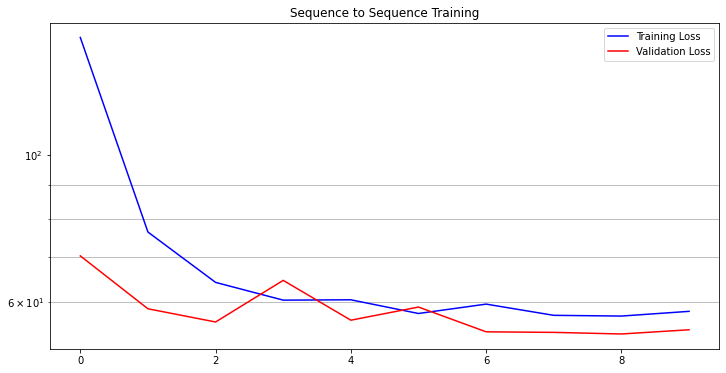

100%|███████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 26082.73it/s]


Epoch 1/30
73/73 [==============================] - 0s 3ms/step - loss: 235.9942 - mae: 0.7403 - val_loss: 84.4929 - val_mae: 0.4619
Epoch 2/30
73/73 [==============================] - 0s 2ms/step - loss: 160.8118 - mae: 0.5478 - val_loss: 71.2544 - val_mae: 0.3478
Epoch 3/30
73/73 [==============================] - 0s 2ms/step - loss: 143.1885 - mae: 0.4625 - val_loss: 66.1769 - val_mae: 0.3131
Epoch 4/30
73/73 [==============================] - 0s 2ms/step - loss: 133.1765 - mae: 0.4297 - val_loss: 65.1623 - val_mae: 0.3050
Epoch 5/30
73/73 [==============================] - 0s 2ms/step - loss: 128.0603 - mae: 0.4088 - val_loss: 62.9254 - val_mae: 0.2996
Epoch 6/30
73/73 [==============================] - 0s 2ms/step - loss: 125.8769 - mae: 0.4026 - val_loss: 61.9238 - val_mae: 0.2969
Epoch 7/30
73/73 [==============================] - 0s 2ms/step - loss: 120.8713 - mae: 0.3854 - val_loss: 61.5527 - val_mae: 0.2896
Epoch 8/30
73/73 [==============================] - 0s 2ms/step - los

  0%|                                                                                           | 0/26 [00:00<?, ?it/s]

******************************************************************************************
Metric weights model: 6.956005096435547, 7.138147830963135
******************************************************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 26/26 [00:18<00:00,  1.39it/s]


******************************************************************************************
Metric base model: 6.894548416137695, 7.08143949508667
******************************************************************************************
******************************************************************************************
Metric ensembled model: 6.867088317871094, 7.060805320739746
******************************************************************************************
Num Fold: 2
Train patients: 151, Test patients: 25
Epoch [1/10]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=Fa

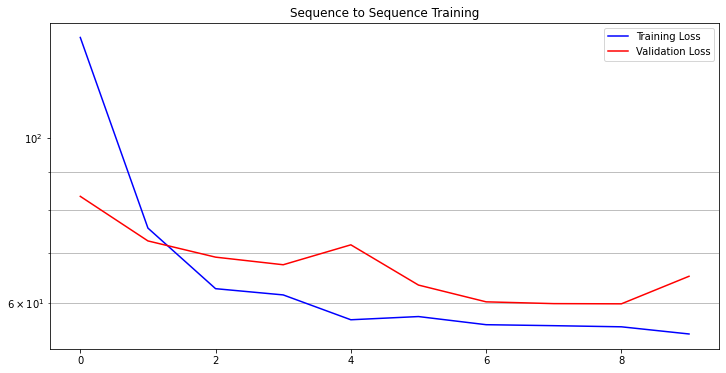

100%|███████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 25061.57it/s]


Epoch 1/30
74/74 [==============================] - 0s 3ms/step - loss: 229.9944 - mae: 0.6688 - val_loss: 118.9727 - val_mae: 0.5738
Epoch 2/30
74/74 [==============================] - 0s 2ms/step - loss: 146.8439 - mae: 0.4930 - val_loss: 83.9989 - val_mae: 0.4076
Epoch 3/30
74/74 [==============================] - 0s 2ms/step - loss: 137.3419 - mae: 0.4410 - val_loss: 76.4976 - val_mae: 0.3794
Epoch 4/30
74/74 [==============================] - 0s 2ms/step - loss: 122.1851 - mae: 0.3983 - val_loss: 76.2941 - val_mae: 0.3359
Epoch 5/30
74/74 [==============================] - 0s 2ms/step - loss: 118.2038 - mae: 0.3747 - val_loss: 73.4093 - val_mae: 0.3462
Epoch 6/30
74/74 [==============================] - 0s 2ms/step - loss: 116.1309 - mae: 0.3717 - val_loss: 73.6545 - val_mae: 0.3293
Epoch 7/30
74/74 [==============================] - 0s 2ms/step - loss: 115.4221 - mae: 0.3693 - val_loss: 69.9670 - val_mae: 0.3254
Epoch 8/30
74/74 [==============================] - 0s 2ms/step - lo

  0%|                                                                                           | 0/25 [00:00<?, ?it/s]

******************************************************************************************
Metric weights model: 7.040679454803467, 7.2198615074157715
******************************************************************************************


100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:16<00:00,  1.47it/s]


******************************************************************************************
Metric base model: 7.045562744140625, 7.322145938873291
******************************************************************************************
******************************************************************************************
Metric ensembled model: 7.0074238777160645, 7.262973785400391
******************************************************************************************
Num Fold: 3
Train patients: 151, Test patients: 25
Epoch [1/10]

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=

KeyboardInterrupt: 

In [8]:
#########################################################################

img_size_load=(260, 260, 1)
img_size_crop=(220, 220, 1)
num_frames_batch = 32
train_alpha = 0.9
val_alpha = 0.9
batch_size = 1
random_window = True

ensembled_coeff = 0.75
s_w_factor = 2

skf = StratifiedKFold(n_splits = 7, random_state = 12, shuffle = True)
list_models, list_history = [], []
list_models_weights, list_history_weights = [], []
list_history_ensembles = []

for num_fold, (train_index, val_index) in enumerate(skf.split(unique_train_patients, 
                                                              np.zeros(unique_train_patients.shape[0]))):

    x_train_patients = list(unique_train_patients[train_index])
    x_val_patients = list(unique_train_patients[val_index])
    
    print(f'Num Fold: {num_fold + 1}')
    print(f'Train patients: {len(x_train_patients)}, Test patients: {len(x_val_patients)}')    

    X_train_generator = SequenceToSequenceDataGenerator(raw_scans=False, training=True, 
                                                        patients=x_train_patients,
                                                        batch_size=batch_size, num_frames_batch=num_frames_batch, 
                                                        alpha=train_alpha, random_window=random_window, center_crop=True,
                                                        img_size_load=img_size_load, img_size_crop=img_size_crop,
                                                        dict_ini_features=dict_patients_train_ini_features, 
                                                        dict_patients_masks_paths=dict_train_patients_masks_paths,
                                                        dict_raw_scans_paths=None)

    X_val_generator = SequenceToSequenceDataGenerator(raw_scans=False, training=False, 
                                                      patients=x_val_patients,
                                                      batch_size=1, num_frames_batch=num_frames_batch, 
                                                      alpha=val_alpha, random_window=random_window, center_crop=True,
                                                      img_size_load=img_size_load, img_size_crop=img_size_crop,
                                                      dict_ini_features=dict_patients_train_ini_features, 
                                                      dict_patients_masks_paths=dict_train_patients_masks_paths,
                                                      dict_raw_scans_paths=None)

    model_inputs['num_fold'] = num_fold
    model = PulmonarFibrosisEncoderDecoder(**model_inputs)

    history = model.fitModel(X_train=X_train_generator, 
                             X_val=X_val_generator,
                             epochs=10)
    
    plotTrainHistory(history, title='Sequence to Sequence Training', scale=True)
    
    list_models.append(model)
    list_history.append(history)
    
    ######################
    
    ## Weights Model
    
    df_train_weights = buildDataSet(x_train_patients, 
                 dict_ini_features=dict_patients_train_ini_features, 
                 dict_seq_weeks=dict_train_sequence_weekssincelastvisit, 
                 dict_seq_cumweeks=dict_train_sequence_cumweeks, 
                 training=True, 
                 predictions=None)

    df_val_weights = buildDataSet(x_val_patients,
                 dict_ini_features=dict_patients_train_ini_features, 
                 dict_seq_weeks=dict_train_sequence_weekssincelastvisit, 
                 dict_seq_cumweeks=dict_train_sequence_cumweeks, 
                 training=True, 
                 predictions=None)
                                               
    features = list(col for col in df_train_weights.columns if col not in ['Patient', 'fvc_real', 'kind'])   
    y_train = df_train_weights['fvc_real'].astype(float)
    y_val = df_val_weights['fvc_real'].astype(float)

    X_train =  df_train_weights[features]
    X_val =  df_val_weights[features]

    model_weights = buildModel(len(features), lambda_factor=0.75)
    
    sample_weight = np.ones(shape=df_train_weights.shape[0])
    idx_l3 = list(df_train_weights.groupby('Patient').tail(3).index)
    sample_weight[idx_l3] = s_w_factor

    model_weights.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      sample_weight=sample_weight,
                      shuffle=True, batch_size=16, 
                      epochs=30, verbose=1)
    
    list_models_weights.append(model_weights)
    
    y_val_pred = model_weights.predict(X_val)
    y_val_pred_median = unscale(y_val_pred[:, 1], mean_fvc, std_fvc)
    y_val_pred_std = unscale(y_val_pred[:, 2], mean_fvc, std_fvc) - unscale(y_val_pred[:, 0], mean_fvc, std_fvc)

    
    metric = customLossFunction(unscale(y_val, mean_fvc, std_fvc),
                                       y_val_pred_median,
                                     y_val_pred_std).numpy()
    
    X_val_last_3 = df_val_weights.groupby('Patient').tail(3)
    y_val_l3 = X_val_last_3['fvc_real']
    
    y_val_pred_l3 = model_weights.predict(X_val_last_3[features])
    y_val_pred_l3_median = unscale(y_val_pred_l3[:, 1], mean_fvc, std_fvc)
    y_val_pred_l3_std = unscale(y_val_pred_l3[:, 2], mean_fvc, std_fvc) - unscale(y_val_pred_l3[:, 0], mean_fvc, std_fvc)
    
    metric_l3 = customLossFunction(unscale(y_val_l3, mean_fvc, std_fvc),
                                           y_val_pred_l3_median,
                                           y_val_pred_l3_std).numpy()
    
    list_history_weights.append({'val_metric' : metric, 'val_Metrict3Timesteps' : metric_l3 })
    print('***'*30)
    print(f'Metric weights model: {metric}, {metric_l3}')
    print('***'*30)
    
    ######################
    
    # Base model
    
    list_weights_predictions = y_val_pred_median
    list_weights_confidences = y_val_pred_std
    list_weights_predictions_l3 = y_val_pred_l3_median
    list_weights_confidences_l3 = y_val_pred_l3_std
    
    list_base_predictions, list_base_confidences = [], []
    list_base_predictions_l3, list_base_confidences_l3 = [], []
    
    for patient in tqdm(x_val_patients, total=len(x_val_patients), position=0):
        list_submission_weeks_elapsed = dict_train_sequence_fvc[patient]
        list_weeks_since_firstvisit = dict_train_sequence_cumweeks[patient]
        base_model_predictions, base_model_stds, _, _ = model.predictEvaluateModel(X_generator=X_val_generator,
                                                         patient=patient, 
                                                         list_weeks_elapsed=list_submission_weeks_elapsed,
                                                         list_weeks_since_firstvisit=list_weeks_since_firstvisit,
                                                         initial_fvc=[dict_patients_train_ini_features[patient]['FVC']])
        
        base_model_predictions = unscale(base_model_predictions.numpy().flatten(), mean_fvc, std_fvc)
        list_base_predictions.extend(base_model_predictions)
        list_base_confidences.extend(base_model_stds.numpy().flatten())
        
        list_base_predictions_l3.extend(base_model_predictions[-3:])
        list_base_confidences_l3.extend(base_model_stds[-3:].numpy().flatten())
        
    metric_base = customLossFunction(y_true=unscale(y_val, mean_fvc, std_fvc),
                                           y_pred=list_base_predictions,
                                           std=list_base_confidences)
    
    metric_base_l3 = customLossFunction(y_true=unscale(y_val_l3, mean_fvc, std_fvc),
                                           y_pred=list_base_predictions_l3,
                                           std=list_base_confidences_l3)
    
    print('***'*30)
    print(f'Metric base model: {metric_base}, {metric_base_l3}')
    print('***'*30)
    
    ######################
    
    # Ensembling
    
    ensembled_predictions = (np.asarray(list_base_predictions) * ensembled_coeff) + (list_weights_predictions * (1-ensembled_coeff))
    ensembled_confidences = (np.asarray(list_base_confidences) * ensembled_coeff) + (list_weights_confidences * (1-ensembled_coeff))
    
    ensembled_predictions_l3 = (np.asarray(list_base_predictions_l3) * ensembled_coeff) + (list_weights_predictions_l3 * (1-ensembled_coeff))
    ensembled_confidences_l3 = (np.asarray(list_base_confidences_l3) * ensembled_coeff) + (list_weights_confidences_l3 * (1-ensembled_coeff))
    
    metric_ensembled = customLossFunction(y_true=unscale(y_val, mean_fvc, std_fvc),
                                           y_pred=ensembled_predictions,
                                           std=ensembled_confidences)
    
    metric_ensembled_l3 = customLossFunction(y_true=unscale(y_val_l3, mean_fvc, std_fvc),
                                             y_pred=ensembled_predictions_l3,
                                             std=ensembled_confidences_l3)
    
    list_history_ensembles.append({'val_metric' : metric_ensembled, 'val_Metrict3Timesteps' : metric_ensembled_l3})
    print('***'*30)
    print(f'Metric ensembled model: {metric_ensembled}, {metric_ensembled_l3}')
    print('***'*30)
    
#########################################################################

In [13]:
#########################################################################

## Base model

base_val_loss = np.mean([history['val_loss'][-1] for history in list_history])
base_val_metric = np.mean([(history['val_metric'][-1]) for history in list_history])
base_val_metric_last3 = np.mean([(history['val_Metrict3Timesteps'][-1]) for history in list_history])

print(base_val_loss, base_val_metric, base_val_metric_last3)

## Weights

weights_val_metric = np.mean([(history['val_metric']) for history in list_history_weights])
weights_val_metric_last3 = np.mean([(history['val_Metrict3Timesteps']) for history in list_history_weights])

print(weights_val_metric, weights_val_metric_last3)

## Ensemble

ensemble_val_metric = np.mean([(history['val_metric']) for history in list_history_ensembles])
ensemble_val_metric_last3 = np.mean([(history['val_Metrict3Timesteps']) for history in list_history_ensembles])

print(ensemble_val_metric, ensemble_val_metric_last3)

#########################################################################

59.773247 7.047446 7.21603
6.9983425 7.1790047
6.937256 7.1618896


In [ ]:
### History models
# 1. ensemble_coeff = 0.5 

# 1.4365882 6.866982 6.9187007
# 7.0161257 7.116428
#-> 6.8267794 6.942761

# 2. ensemble_coeff = 0.7 

# 1.4366915 6.866254 6.91714
# 6.9919753 7.1083403
#-> 6.7669153 6.8837447

---

In [14]:
num_folds = 3
ensembled_coeff = 0.7
list_base_h = []
list_weights_h = []
list_ensembled_h = []

for n_fold in range(num_folds):
    
    X_sub_generator = SequenceToSequenceDataGenerator(raw_scans=False, training=True, 
                                                        patients=unique_train_patients,
                                                        batch_size=batch_size, num_frames_batch=num_frames_batch, 
                                                        alpha=train_alpha, random_window=random_window, center_crop=True,
                                                        img_size_load=img_size_load, img_size_crop=img_size_crop,
                                                        dict_ini_features=dict_patients_train_ini_features, 
                                                        dict_patients_masks_paths=dict_train_patients_masks_paths,
                                                        dict_raw_scans_paths=None)
    
    
    df_sub_weights = buildDataSet(unique_train_patients, 
                 dict_ini_features=dict_patients_train_ini_features, 
                 dict_seq_weeks=dict_train_sequence_weekssincelastvisit, 
                 dict_seq_cumweeks=dict_train_sequence_cumweeks, 
                 training=True, 
                 predictions=None)
   
    #################
    ## Weights

    X_sub_weights = df_sub_weights[features]
    y_sub = df_sub_weights['fvc_real'].astype(float)
    
    y_sub_pred = list_models_weights[n_fold].predict(X_sub_weights)
    y_sub_pred_median = unscale(y_sub_pred[:, 1], mean_fvc, std_fvc)
    y_sub_pred_std = unscale(y_sub_pred[:, 2], mean_fvc, std_fvc) - unscale(y_sub_pred[:, 0], mean_fvc, std_fvc)

    sub_weights_metric = customLossFunction(unscale(y_sub, mean_fvc, std_fvc),
                                                    y_sub_pred_median,
                                                    y_sub_pred_std).numpy()
    
    X_sub_last_3 = df_sub_weights.groupby('Patient').tail(3)
    y_sub_l3 = X_sub_last_3['fvc_real']
    
    y_sub_pred_l3 = list_models_weights[n_fold].predict(X_sub_last_3[features])
    y_sub_pred_l3_median = unscale(y_sub_pred_l3[:, 1], mean_fvc, std_fvc)
    y_sub_pred_l3_std = unscale(y_sub_pred_l3[:, 2], mean_fvc, std_fvc) - unscale(y_sub_pred_l3[:, 0], mean_fvc, std_fvc)
    
    sub_weights_metric_l3 = customLossFunction(unscale(y_sub_l3, mean_fvc, std_fvc),
                                                       y_sub_pred_l3_median,
                                                       y_sub_pred_l3_std).numpy()
    
    print('***'*30)
    print(f'Metric sub weights model: {sub_weights_metric}, {sub_weights_metric_l3}')
    print('***'*30)
    
    list_sub_weights_predictions = y_sub_pred_median
    list_sub_weights_confidences = y_sub_pred_std
    list_sub_weights_predictions_l3 = y_sub_pred_l3_median
    list_sub_weights_confidences_l3 = y_sub_pred_l3_std
    
    #################
    ## Base
    
    list_sub_base_predictions, list_sub_base_confidences = [], []
    list_sub_base_predictions_l3, list_sub_base_confidences_l3 = [], []
    
    for patient in tqdm(unique_train_patients, total=len(unique_train_patients), position=0):
        list_submission_weeks_elapsed = dict_train_sequence_fvc[patient]
        list_weeks_since_firstvisit = dict_train_sequence_cumweeks[patient]
        base_sub_model_predictions, base_sub_model_stds, _, _ = list_models[n_fold].predictEvaluateModel(X_generator=X_sub_generator,
                                                         patient=patient, 
                                                         list_weeks_elapsed=list_submission_weeks_elapsed,
                                                         list_weeks_since_firstvisit=list_weeks_since_firstvisit,
                                                         initial_fvc=[dict_patients_train_ini_features[patient]['FVC']])
        
        base_sub_model_predictions = unscale(base_sub_model_predictions.numpy().flatten(), mean_fvc, std_fvc)
        list_sub_base_predictions.extend(base_sub_model_predictions)
        list_sub_base_confidences.extend(base_sub_model_stds.numpy().flatten())
        
        list_sub_base_predictions_l3.extend(base_sub_model_predictions[-3:])
        list_sub_base_confidences_l3.extend(base_sub_model_stds[-3:].numpy().flatten())
        
    sub_base_metric = customLossFunction(y_true=unscale(y_sub, mean_fvc, std_fvc),
                                               y_pred=list_sub_base_predictions,
                                               std=list_sub_base_confidences)
    
    sub_base_metric_l3 = customLossFunction(y_true=unscale(y_sub_l3, mean_fvc, std_fvc),
                                           y_pred=list_sub_base_predictions_l3,
                                           std=list_sub_base_confidences_l3)
    
    print('***'*30)
    print(f'Metric sub base model: {sub_base_metric}, {sub_base_metric_l3}')
    print('***'*30)
    
    #################
    ## Ensembling
    
    ensembled_sub_predictions = (np.asarray(list_sub_base_predictions) * ensembled_coeff) + (list_sub_weights_predictions * (1-ensembled_coeff))
    ensembled_sub_confidences = (np.asarray(list_sub_base_confidences) * ensembled_coeff) + (list_sub_weights_confidences * (1-ensembled_coeff))
    
    ensembled_sub_predictions_l3 = (np.asarray(list_sub_base_predictions_l3) * ensembled_coeff) + (list_sub_weights_predictions_l3 * (1-ensembled_coeff))
    ensembled_sub_confidences_l3 = (np.asarray(list_sub_base_confidences_l3) * ensembled_coeff) + (list_sub_weights_confidences_l3 * (1-ensembled_coeff))
    
    sub_metric_ensembled = customLossFunction(y_true=unscale(y_sub, mean_fvc, std_fvc),
                                           y_pred=ensembled_sub_predictions,
                                           std=ensembled_sub_confidences)
    
    sub_metric_ensembled_l3 = customLossFunction(y_true=unscale(y_sub_l3, mean_fvc, std_fvc),
                                             y_pred=ensembled_sub_predictions_l3,
                                             std=ensembled_sub_confidences_l3)
    
    print('***'*30)
    print(f'Metric ensembled model: {sub_metric_ensembled}, {sub_metric_ensembled_l3}')
    print('***'*30)
    
    #################
    
    list_base_h.append({'metric' : sub_base_metric, 'Metrict3Timesteps' : sub_base_metric_l3})
    list_weights_h.append({'metric' : sub_weights_metric, 'Metrict3Timesteps' : sub_weights_metric_l3})
    list_ensembled_h.append({'metric' : sub_metric_ensembled, 'Metrict3Timesteps' : sub_metric_ensembled_l3})
    

#################


base_sub_metric = np.mean([(history['metric']) for history in list_base_h])
base_sub_metric_last3 = np.mean([(history['Metrict3Timesteps']) for history in list_base_h])

print(base_sub_metric, base_sub_metric_last3)

## Weights

weights_sub_metric = np.mean([(history['metric']) for history in list_weights_h])
weights_sub_metric_last3 = np.mean([(history['Metrict3Timesteps']) for history in list_weights_h])

print(weights_sub_metric, weights_sub_metric_last3)

## Ensemble

ensemble_sub_metric = np.mean([(history['metric']) for history in list_ensembled_h])
ensemble_sub_metric_last3 = np.mean([(history['Metrict3Timesteps']) for history in list_ensembled_h])

print(ensemble_sub_metric, ensemble_sub_metric_last3)

#################

  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

******************************************************************************************
Metric sub weights model: 6.910582542419434, 7.029907703399658
******************************************************************************************


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

******************************************************************************************
Metric sub base model: 6.917273044586182, 7.020876407623291
******************************************************************************************
******************************************************************************************
Metric ensembled model: 6.863484859466553, 6.981986999511719
******************************************************************************************
******************************************************************************************
Metric sub weights model: 6.873198509216309, 6.982013702392578
******************************************************************************************


  0%|                                                                                          | 0/176 [00:00<?, ?it/s]

******************************************************************************************
Metric sub base model: 6.892694473266602, 6.997180938720703
******************************************************************************************
******************************************************************************************
Metric ensembled model: 6.849411964416504, 6.967347621917725
******************************************************************************************
******************************************************************************************
Metric sub weights model: 6.910279750823975, 7.031265735626221
******************************************************************************************


100%|████████████████████████████████████████████████████████████████████████████████| 176/176 [02:25<00:00,  1.21it/s]

******************************************************************************************
Metric sub base model: 6.847013473510742, 7.01287841796875
******************************************************************************************
******************************************************************************************
Metric ensembled model: 6.850027561187744, 7.006999969482422
******************************************************************************************
6.88566 7.0103116
6.8980203 7.014395
6.8543077 6.985445
